In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import albumentations as A
import cv2
import itertools
import os
import time
from pathlib import Path
from tqdm.notebook import tqdm
import math
from scipy import ndimage

# pytorch stuff
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

# need for AMP
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

torch.manual_seed(3)

## Data

1. To get the data go to https://www.cityscapes-dataset.com/ and register. Then download these files:
`gtFine_trainvaltest.zip` and `leftImg8bit_trainvaltest.zip`. Put the data in your gpu and unzip.

2. Go to directory `utils` open the file `preprocess_data.py` and replace the following paths
`cityscapes_data_path` and `cityscapes_meta_path`.

3. Run `python preprocess_data.py`

In [2]:
PATH = Path('/data2/yinterian/cityscapes/')

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [10]:
list((PATH/"leftImg8bit/train/zurich").iterdir())[:10] 

[PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000051_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000092_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000117_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000003_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000071_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000040_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000121_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000048_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000045_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/tra

In [11]:
list((PATH/"gtFine/train/zurich").iterdir())[:10] 

[PosixPath('/data2/yinterian/cityscapes/gtFine/train/zurich/zurich_000066_000019_gtFine_instanceIds.png'),
 PosixPath('/data2/yinterian/cityscapes/gtFine/train/zurich/zurich_000001_000019_gtFine_labelIds.png'),
 PosixPath('/data2/yinterian/cityscapes/gtFine/train/zurich/zurich_000105_000019_gtFine_color.png'),
 PosixPath('/data2/yinterian/cityscapes/gtFine/train/zurich/zurich_000061_000019_gtFine_color.png'),
 PosixPath('/data2/yinterian/cityscapes/gtFine/train/zurich/zurich_000068_000019_gtFine_color.png'),
 PosixPath('/data2/yinterian/cityscapes/gtFine/train/zurich/zurich_000107_000019_gtFine_instanceIds.png'),
 PosixPath('/data2/yinterian/cityscapes/gtFine/train/zurich/zurich_000069_000019_gtFine_instanceIds.png'),
 PosixPath('/data2/yinterian/cityscapes/gtFine/train/zurich/zurich_000050_000019_gtFine_labelIds.png'),
 PosixPath('/data2/yinterian/cityscapes/gtFine/train/zurich/zurich_000109_000019_gtFine_instanceIds.png'),
 PosixPath('/data2/yinterian/cityscapes/gtFine/train/zurich/z

(<matplotlib.image.AxesImage at 0x7fa6bc382490>, (1024, 2048, 3))

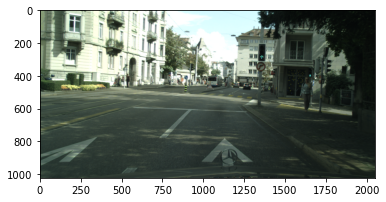

In [17]:
path = PATH/"leftImg8bit/train/zurich/zurich_000051_000019_leftImg8bit.png"
im = read_image(path)
plt.imshow(im), im.shape

(<matplotlib.image.AxesImage at 0x7fa6bc1fe160>, (1024, 2048, 3))

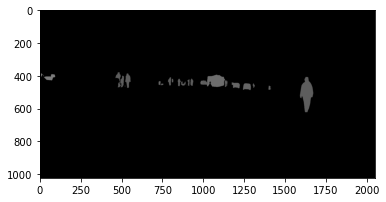

In [29]:
path = PATH/"gtFine/train/zurich/zurich_000051_000019_gtFine_instanceIds.png"
im = read_image(path)
plt.imshow(im), im.shape

In [30]:
im.reshape(-1).min(), im.reshape(-1).max()

(0, 125)